# Intro 

There are two main streams of studies that attempt to understand factors and conditions that lead to price changes or even to forecast future stock prices, fundamental analysis and technical analysis:

* **Fundamental analysis**: This stream focuses on underlying factors that influence a company's value and business, including overall economy and industry conditions from macro perspectives, the company's financial conditions, management, and competitors from micro perspectives.
* **Technical analysis**: On the other hand, this stream predicts future price movements through the statistical study of past trading activity, including price movement, volume, and market data. Predicting prices via machine learning techniques is an important topic in technical analysis nowadays.

In this notebook, we'll be working as a quantitative analyst/researcher, exploring how to predict stock prices with several typical machine learning regression algorithms.


## Stock index

A **stock index** is a statistical measure of the value of a portion of the overall stock market. An index includes several stocks that are diverse enough to represent a section of the whole market. And the price of an index is typically computed as the weighted average of the prices of selected stocks.

## Stock price data

We can apply regression techniques to predicting prices of a particular stock. However, it's difficult to ensure the stock we pick is suitable for learning purposes — its price should follow some learnable patterns and it can't have been affected by unprecedented instances or irregular events. 

Hence, we'll be focusing on one of the most popular stock indexes to better illustrate and generalize our price regression approach.

The Dow Jones Industrial Average (DJIA) is one of the longest established and most commonly watched indexes in the world. It consists of 30 of the most significant stocks in the U.S., such as Microsoft, Apple, General Electric, and the Walt Disney Company, and represents around a quarter of the value of the entire U.S. market. You can view its daily prices and performance on Yahoo Finance at 
https://finance.yahoo.com/quote/%5EDJI/history?p=%5EDJI.

# Get the data

We will acquire stock index price and performance data from Yahoo Finance using the [yfinance](https://pypi.org/project/yfinance/) Python library.


In [5]:
# pip install yfinance

In [68]:
import pandas as pd
import yfinance as yf

In [69]:
start_date= '1988-01-01'
end_date= '2019-12-31'
ticker= '^DJI'
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [70]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1992-01-02,3152.100098,3172.629883,3139.310059,3172.399902,3172.399902,23550000
1992-01-03,3172.399902,3210.639893,3165.919922,3201.500000,3201.500000,23620000
1992-01-06,3201.500000,3213.330078,3191.860107,3200.100098,3200.100098,27280000
1992-01-07,3200.100098,3210.199951,3184.479980,3204.800049,3204.800049,25510000
1992-01-08,3204.800049,3229.199951,3185.820068,3203.899902,3203.899902,29040000
...,...,...,...,...,...,...
2019-12-23,28491.779297,28582.490234,28491.779297,28551.529297,28551.529297,223530000
2019-12-24,28572.570312,28576.800781,28503.210938,28515.449219,28515.449219,86150000
2019-12-26,28539.460938,28624.099609,28535.150391,28621.390625,28621.390625,155970000


In [71]:
data.to_csv("../datasets/19880101_20191231.csv")

# Feature engineering

We can compute the average close price over the past week (five trading days), over the past month, and over the past year as three new features. We can also customize the time window to the size we want, such as the past quarter or the past six months. On top of these three averaged price features, we can generate new features associated with the price trend by computing the ratios between each pair of average prices in the three different time frames, for instance, the ratio between the average price over the past week and over the past year.

Similarly, we can generate new volume-based features by computing the average volumes in several different time frames and the ratios between each pair of averaged values.

We should also consider stock volatility. Volatility describes the degree of variation of prices for a given stock or index over time. In statistical terms, it's basically the standard deviation of the close prices. We can easily generate new sets of features by computing the standard deviation of close prices in a particular time frame, as well as the standard deviation of volumes traded. In a similar manner, ratios between each pair of standard deviation values can be included in our engineered feature pool.

Last but not least, return is a significant financial metric that investors closely watch for. Return is the percentage of gain or loss of close price for a stock/index in a particular period. For example, daily return and annual return are financial terms we frequently hear. They are calculated as follows:
$$ \text{ return}_{i:i-1} = \frac{\text{price}_i - \text{price}_{i-1}}{ \text{price}_{i-1}}$$
$$ \text{ return}_{i:i-365} = \frac{\text{price}_i - \text{price}_{i-365}}{ \text{price}_{i-365}}$$

Here, $\text{price}_i$ is the price on the $i$th day. Weekly and monthly returns can be computed in a similar way. Based on daily returns, we can produce a moving average over a particular number of days.

For instance, given daily returns of the past week, we can calculate the moving average over that week as follows:

$$\text{MovingAvg}_{i_5}=\frac{\text{ return}_{i:i-1} + \text{ return}_{i-1:i-2}+\text{ return}_{i-2:i-3}+\text{ return}_{i-3:i-4}+\text{ return}_{i-4:i-5}}{5}$$

In [72]:
def generate_features(df):
    """
    Generate features for a stock/index based on historical price and performance
    @param df: dataframe with columns "Open", "Close", "High", "Low", "Volume", "Adjusted Close"
    @return: dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    # 6 original features
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    # 31 generated features
    # average price
    df_new['avg_price_5'] = df['Close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # average volume
    df_new['avg_volume_5'] = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # standard deviation of prices
    df_new['std_price_5'] = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # standard deviation of volumes
    df_new['std_volume_5'] = df['Volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # return
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    # the target
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new

In [73]:
df = generate_features(data)

In [74]:
df.round(decimals=3).head(5)

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_365,ratio_avg_price_5_30,...,ratio_std_volume_5_365,ratio_std_volume_30_365,return_1,return_5,return_30,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-04,3301.1,3321.1,3301.11,3327.86,3301.11,13860000.0,3318.494,3303.572,3284.851,1.005,...,1.098,1.559,-0.006,-0.004,0.002,0.031,0.000,0.0,0.0,3309.2
1993-01-05,3309.2,3301.1,3309.20,3319.21,3298.68,21400000.0,3315.094,3304.662,3285.284,1.003,...,0.970,1.562,0.002,-0.005,0.007,0.034,-0.001,0.0,0.0,3307.9
1993-01-06,3307.9,3309.2,3307.90,3320.83,3300.57,28060000.0,3310.022,3306.158,3285.693,1.001,...,1.145,1.571,-0.000,-0.008,0.010,0.032,-0.001,0.0,0.0,3305.2
1993-01-07,3305.2,3307.9,3305.20,3312.19,3290.58,35790000.0,3308.902,3306.943,3286.095,1.001,...,1.692,1.639,-0.001,-0.002,0.005,0.032,-0.002,0.0,0.0,3269.0
1993-01-08,3269.0,3305.2,3269.00,3313.27,3260.86,36820000.0,3298.482,3305.120,3286.331,0.998,...,1.807,1.704,-0.011,-0.016,-0.012,0.019,-0.000,0.0,0.0,3251.7


In [75]:
df.shape

(6798, 38)

In [10]:
start_train = '1988-01-01'
end_train = '2018-12-31'

start_test = '2019-01-01'
end_test = '2019-12-31'

df_train = df.loc[start_train:end_train]
X_train = df_train.drop('close', axis=1).values
y_train = df_train['close'].values

In [76]:
X_train.shape

(6547, 37)

In [77]:
df_test = df.loc[start_test:end_test]
X_test = df_test.drop('close', axis=1).values
y_test = df_test['close'].values

# Linear regression

SGD based algorithms are sensitive to data with features at very different scales. This means that we need to normalize features into the same or comparable scale. 

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [79]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [80]:
param_grid = {
    "alpha": [1e-4, 3e-4, 1e-3],
    "eta0": [0.01, 0.03, 0.1],
}

In [81]:
lr = SGDRegressor(penalty='l2',
                  max_iter=1000,
                  random_state=42)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SGDRegressor(random_state=42),
             param_grid={'alpha': [0.0001, 0.0003, 0.001],
                         'eta0': [0.01, 0.03, 0.1]},
             scoring='r2')

In [82]:
grid_search.best_params_

{'alpha': 0.0001, 'eta0': 0.01}

In [83]:
lr_best = grid_search.best_estimator_
pred_lr = lr_best.predict(X_test_scaled)

In [99]:
print(f'Linear Regression MSE: {mean_squared_error(y_test, pred_lr):.3f}')
print(f'Linear Regression MAE: {mean_absolute_error(y_test, pred_lr):.3f}')
print(f'Linear Regression R^2: {r2_score(y_test, pred_lr):.3f}')

Linear Regression MSE: 43200.359
Linear Regression MAE: 156.997
Linear Regression R^2: 0.962


# Random forest

In [85]:
from sklearn.ensemble import RandomForestRegressor

In [86]:
param_grid = {
    'max_depth': [30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 5]
}

In [87]:
rf = RandomForestRegressor(n_estimators=100,
                           n_jobs=-1,
                           max_features=1.0,
                           random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [30, 50], 'min_samples_leaf': [3, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='r2')

In [88]:
grid_search.best_params_

{'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 10}

In [89]:
rf_best = grid_search.best_estimator_
pred_rf = rf_best.predict(X_test)

In [101]:
print(f'Random forest MSE: {mean_squared_error(y_test, pred_rf):.3f}')
print(f'Random forest MAE: {mean_absolute_error(y_test, pred_rf):.3f}')
print(f'Random forest R^2: {r2_score(y_test, pred_rf):.3f}')

Random forest MSE: 415269.945
Random forest MAE: 417.476
Random forest R^2: 0.638


# Support vector regression

Similar to SGD based algorithms, SVR doesn't work well on data with feature scale disparity, so we will use the scaled data.

In [91]:
from sklearn.svm import SVR

In [92]:
param_grid = [
    {'kernel': ['linear'], 'C': [100, 300, 500],
     'epsilon': [0.00003, 0.0001]},
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
     'C': [10, 100, 1000], 'epsilon': [0.00003, 0.0001]}
]

In [93]:
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [100, 300, 500], 'epsilon': [3e-05, 0.0001],
                          'kernel': ['linear']},
                         {'C': [10, 100, 1000], 'epsilon': [3e-05, 0.0001],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
             scoring='r2')

In [94]:
grid_search.best_params_

{'C': 500, 'epsilon': 3e-05, 'kernel': 'linear'}

In [95]:
svr_best = grid_search.best_estimator_
pred_svr = svr_best.predict(X_test_scaled)

In [103]:
print(f'Support vector regression MSE: {mean_squared_error(y_test, pred_svr):.3f}')
print(f'Support vector regression MAE: {mean_absolute_error(y_test, pred_svr):.3f}')
print(f'Support vector regression R^2: {r2_score(y_test, pred_svr):.3f}')

Support vector regression MSE: 29486.743
Support vector regression MAE: 122.581
Support vector regression R^2: 0.974


# Neural network

In [128]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorboard.plugins.hparams import api as hp
from tensorboard import notebook

## Initialize hyperparameters to optimize

In [111]:
HP_HIDDEN = hp.HParam('hidden_size', hp.Discrete([64, 32, 16]))
HP_EPOCHS = hp.HParam('epochs', hp.Discrete([300, 1000]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.RealInterval(0.01, 0.4))

## Train and validate the model 


In [112]:
def train_test_model(hparams, logdir):
    
    model = Sequential([
        Dense(units=hparams[HP_HIDDEN], activation='relu'),
        Dense(units=1)
    ])
    
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(hparams[HP_LEARNING_RATE]),
                  metrics=['mean_squared_error'])
    
    model.fit(X_train_scaled,
              y_train,
              validation_data=(X_test_scaled, y_test),
              epochs=hparams[HP_EPOCHS], 
              verbose=False,
              callbacks=[
                  tf.keras.callbacks.TensorBoard(logdir),
                  hp.KerasCallback(logdir, hparams),
                  tf.keras.callbacks.EarlyStopping(
                      monitor='val_loss', 
                      min_delta=0,
                      patience=200,
                      verbose=0,
                      mode='auto',
                  )
              ])
    
    _, mse = model.evaluate(X_test_scaled, y_test)
    pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, pred)
    return mse, r2  

The TensorBoard callback function provides visualization for the model graph and metrics during training and validation.

The hyperparameters logging callback logs the hyperparameters and metrics.

The early stopping callback monitors the performance on the validation set, which is the testing set in our case. If the MSE doesn't decrease after 200 epochs, it stops the training process.

In [113]:
def run(hparams, logdir):
    with tf.summary.create_file_writer(logdir).as_default(): 
        hp.hparams_config(
            hparams=[HP_HIDDEN, HP_EPOCHS, HP_LEARNING_RATE],
        metrics=[hp.Metric('mean_squared_error', display_name='mse'),
                 hp.Metric('r2', display_name='r2')],
    )
    mse, r2 = train_test_model(hparams, logdir)
    tf.summary.scalar('mean_squared_error', mse, step=1)
    tf.summary.scalar('r2', r2, step=1)

In [114]:
session_num = 1
for hidden in HP_HIDDEN.domain.values:
    for epochs in HP_EPOCHS.domain.values: 
        for learning_rate in tf.linspace(HP_LEARNING_RATE.domain.min_value,
                                         HP_LEARNING_RATE.domain.max_value,
                                         5):
            hparams = {
                HP_HIDDEN: hidden,
                HP_EPOCHS: epochs,
                HP_LEARNING_RATE: float("%.2f"%float(learning_rate)),
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run(hparams, 'logs/hparam_tuning/' + run_name)
            session_num += 1

--- Starting trial: run-1
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.01}
8/8 [==============================] - 0s 509us/step
--- Starting trial: run-2
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.11}
8/8 [==============================] - 0s 439us/step
--- Starting trial: run-3
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.21}
8/8 [==============================] - 0s 468us/step
--- Starting trial: run-4
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.3}
8/8 [==============================] - 0s 467us/step
--- Starting trial: run-5
{'hidden_size': 16, 'epochs': 300, 'learning_rate': 0.4}
8/8 [==============================] - 0s 431us/step
--- Starting trial: run-6
{'hidden_size': 16, 'epochs': 1000, 'learning_rate': 0.01}
8/8 [==============================] - 0s 501us/step
--- Starting trial: run-7
{'hidden_size': 16, 'epochs': 1000, 'learning_rate': 0.11}
8/8 [==============================] - 0s 482us/step
--- Starting trial: run-8
{'hidden_size':

The combination of **{'hidden_size': 64, 'epochs': 1000, 'learning_rate': 0.3}** is
the best performing one.

In [125]:
model = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=1)
])
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.3))
    
model.fit(X_train_scaled, y_train, epochs=1000, verbose=False)

In [129]:
pred_nn = model.predict(X_test_scaled)[:, 0]

8/8 [==============================] - 0s 622us/step


In [130]:
print(f'Neural network MSE: {mean_squared_error(y_test, pred_nn):.3f}')
print(f'Neural network MAE: {mean_absolute_error(y_test, pred_nn):.3f}')
print(f'Neural network R^2: {r2_score(y_test, pred_nn):.3f}')

Neural network MSE: 28919.019
Neural network MAE: 124.219
Neural network R^2: 0.975


The combination of (hidden_size=16, epochs=1000, learning_rate=0.21) is
the best performing one.

# Model comparison and conclusion

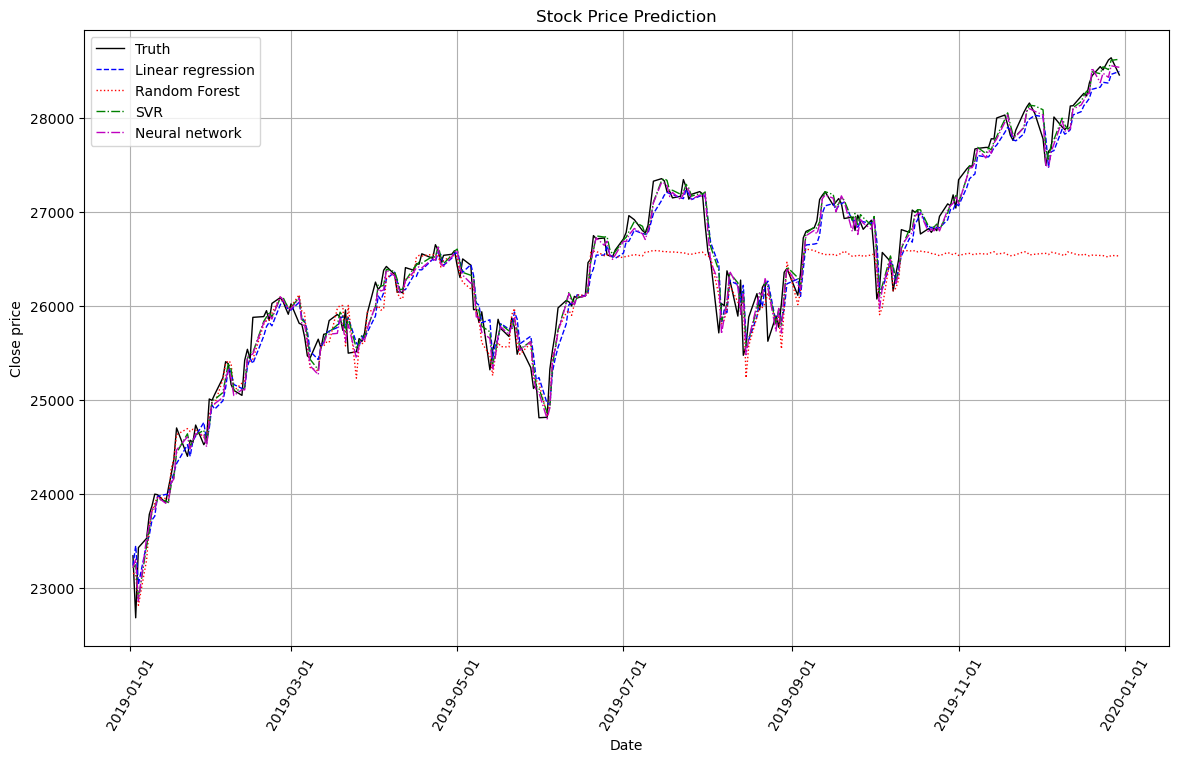

In [132]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 8))

plt.plot(df_test.index, y_test, c='k', linestyle='-', linewidth=1)
plt.plot(df_test.index, pred_lr, c='b', linestyle='--', linewidth=1)
plt.plot(df_test.index, pred_rf, c='r', linestyle=':', linewidth=1)
plt.plot(df_test.index, pred_svr, c='g', linestyle='-.', linewidth=1)
plt.plot(df_test.index, pred_nn, c='m', linestyle='-.', linewidth=1)

plt.xticks(rotation=60)
plt.xlabel('Date')
plt.ylabel('Close price')
plt.legend(['Truth', 'Linear regression', 'Random Forest', 'SVR', 'Neural network'])
plt.grid(True)
plt.title('Stock Price Prediction')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.show()

We've built a stock predictor using four regression algorithms: Linear Regression, Random Forest, Support Vector Regression, and Neural Network. These models were assessed using three key metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and $R^2$ coefficient.

Here is a summary table:

| METRIC         | Linear Regression | Random Forest  | Support Vector Regression| Neural Network |
| :----------------|  :----------------|----------------| -------------------------| ---------------| 
| MSE              | 43200.359         |  415269.945    |  29486.743               | 28919.019      |   
| MAE              | 156.997           |  417.476       |  122.581                 | 124.219      |
| $R^2$            | 0.962             |   0.638        |  0.974                   | 0.975        |


Considering the overall performance across these metrics, it can be concluded that the Neural Network and Support Vector Regression models outperformed the Linear Regression and Random Forest models. These two models consistently achieved lower MSE and MAE values, indicating their superior predictive accuracy. Moreover, both models exhibited high $R^2$ values, indicating their strong ability to explain the variance in the data.

In conclusion, based on the evaluation of these metrics, the Support Vector Regression and Neural Network models are recommended for further consideration and potential deployment in this machine learning project.